# Quantum Discriminative Restricted Boltzmann Machine

Quantum Discriminative Restricted Boltzmann Machine (QDRBM) is a statistical learning model for pattern recognition. QDRBM has three-layer architecture including a input, hidden, and output layer. In addition, we employ transvers field Ising model in the hidden layer of QDRBM. This notebook demonstrates an example of QDRBM with MNIST, Fashon-MNIST, or CIFAR10.

In [1]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2024-11-01 22:40:51.211303: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-01 22:40:51.250194: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-01 22:40:51.250235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-01 22:40:51.251289: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-01 22:40:51.257653: I tensorflow/core/platform/cpu_feature_guar

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15916182860242192722
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 48718282752
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 12847135903525850816
 physical_device_desc: "device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6"
 xla_global_id: 416903419,
 name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 49021648896
 locality {
   bus_id: 2
   numa_node: 1
   links {
     link {
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 9044377813431140418
 physical_device_desc: "device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:af:00.0, compute capability: 8.6"
 xla_global_id: 2144165316]

2024-11-01 22:40:53.201547: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:1 with 46750 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:af:00.0, compute capability: 8.6


## Data preparation

### Load Data

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
#mnist = tf.keras.datasets.mnist
#(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
#cifar10 = tf.keras.datasets.cifar10
#(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
#train_labels = train_labels[:, 0]
#test_labels = test_labels[:, 0]

### Noarmalization of images

Input data are scaled from (0, 255) to a range of (0., +1.)

In [3]:
train_images = tf.cast(train_images/255, dtype=tf.float32)
test_images = tf.cast(test_images /255, dtype=tf.float32)

2024-11-01 22:40:53.861224: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46461 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-11-01 22:40:53.862262: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46750 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:af:00.0, compute capability: 8.6


### Data flattening

In [4]:
x_train = tf.reshape(train_images, [train_images.shape[0], -1])
x_test = tf.reshape(test_images, [test_images.shape[0], -1])

### Onehot representation of labels

In [5]:
y_train = tf.one_hot(train_labels, 10)
y_test = tf.one_hot(test_labels, 10)

### Scaling data range as [0,1]->[-1,1]

In [6]:
x_train = 2*x_train - 1
x_test = 2*x_test - 1
y_train = 2*y_train - 1
y_test = 2*y_test - 1

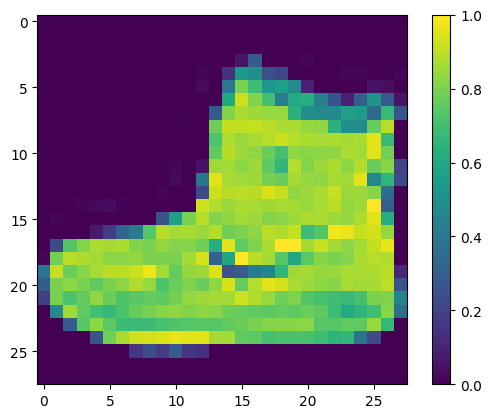

In [7]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

## Create and Train QDRBM

In [8]:
from layers import *
from qdrbm import DRBM
from loss import negative_loglikelihood

initializer = 'glorot_uniform'
quantum_initializer = 'glorot_uniform'

### Create QDRBM model

We create QDRBM model with discriminative restricted Boltzmann machine (DRBM). The DRBM classsupport only architecture including a input, hidden, and output layer. If we use RBMLayer instead of QRBMLayer in the below example, we can define the conventional DRBM model.

In [9]:
model = DRBM(num_classes=10)
model.add(InputLayer(num_input_units=x_train[0].shape[0]))
model.add(QRBMLayer(500, 
    weight_initializer=initializer))
model.add(RBMLayer(10, weight_initializer=initializer))

In [10]:
model.summary()

Model: "drbm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 qrbm_layer (QRBMLayer)      (None, 500)               393000    
                                                                 
 rbm_layer (RBMLayer)        (None, 10)                5010      
                                                                 
Total params: 398010 (1.52 MB)
Trainable params: 398010 (1.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    #run_eagerly=True,
    loss=[negative_loglikelihood],
    metrics=[tf.keras.metrics.CategoricalAccuracy()])

### Train model

In [12]:
history = model.fit(
    x_train,
    y_train,
    epochs=100, 
    validation_data=(x_test, y_test),
    batch_size=100)

Epoch 1/100


2024-11-01 22:40:57.301157: I external/local_xla/xla/service/service.cc:168] XLA service 0x782bec8e7c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-01 22:40:57.301190: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-11-01 22:40:57.301197: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2024-11-01 22:40:57.307854: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-01 22:40:57.331251: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1730468457.402347   44996 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


600/600 [==============================] - 6s 7ms/step - loss: 0.5231 - categorical_accuracy: 0.8192 - val_loss: 0.4271 - val_categorical_accuracy: 0.8462
Epoch 2/100
600/600 [==============================] - 4s 7ms/step - loss: 0.3753 - categorical_accuracy: 0.8644 - val_loss: 0.4344 - val_categorical_accuracy: 0.8479
Epoch 3/100
600/600 [==============================] - 4s 7ms/step - loss: 0.3396 - categorical_accuracy: 0.8755 - val_loss: 0.3980 - val_categorical_accuracy: 0.8583
Epoch 4/100
600/600 [==============================] - 4s 7ms/step - loss: 0.3170 - categorical_accuracy: 0.8822 - val_loss: 0.3876 - val_categorical_accuracy: 0.8659
Epoch 5/100
600/600 [==============================] - 4s 7ms/step - loss: 0.2942 - categorical_accuracy: 0.8905 - val_loss: 0.3713 - val_categorical_accuracy: 0.8694
Epoch 6/100
600/600 [==============================] - 4s 7ms/step - loss: 0.2799 - categorical_accuracy: 0.8960 - val_loss: 0.3462 - val_categorical_accuracy: 0.8758
Epoch 7/10

### Check prediction accuracy

In [15]:
results = model.evaluate(
    x_test,
    y_test)
print(results)

313/313 [==============================] - 1s 4ms/step - loss: 0.7318 - categorical_accuracy: 0.8792
[0.7318017482757568, 0.8791999816894531]


### Plot history

<Axes: >

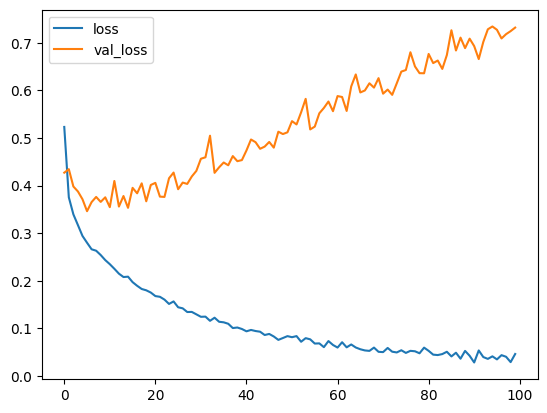

In [14]:
import pandas as pd
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()